# RFM客户分类

## 背景

通过建立合理的客户价值评估模型，对客户进行分群，分析比较不同客户群的客户价值，并制定相应的营销策略，对不同的客户群提供个性化的客户服务。或将有限的营销资源集中于高价值客户，实现企业利润最大化目标。越来越成为客户关系管理中亟待解决的关键问题。 

## 目的

- 根据销售订单数据，建立客户评分模型，对客户进行分类。
- 对不同类型的客户制定个性化营销策略。

## 数据

来源于某公司电商平台2017年11月到18年4月订单脱敏数据，共27794条数据。

## 数据加载

In [1]:
import time  
import numpy as np  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sns.set(style='white')
plt.rc('font', family='SimHei', size=10)

In [3]:
data = pd.read_excel('.\data\order.xlsx',index_col='用户名')

In [4]:
data.head()

,付款日期,订单金额
用户名,,
emoximoxi_n,2018-04-30 21:49:43,144.45
之初雄,2018-04-30 20:22:51,24.50
uchuejn,2018-04-30 20:15:58,49.00
0蓝蝶201112,2018-04-30 18:52:34,24.50
agaoyunjn,2018-04-30 18:40:19,144.45


In [5]:
data.tail()

,付款日期,订单金额
用户名,,
m姹紫嫣红m,2017-11-01 09:01:35,24.5
萝污萌莉,2017-11-01 07:48:48,26.5
2徐杰09,2017-11-01 07:32:32,24.5
0cyb1992,2017-11-01 00:59:54,24.5
2我姓李8,2017-11-01 00:17:59,15.5


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27793 entries, emoximoxi_n to 2我姓李8
Data columns (total 2 columns):
付款日期    27793 non-null datetime64[ns]
订单金额    27793 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 651.4+ KB


In [7]:
data.describe()

,订单金额
count,27793.000000
mean,54.038455
std,50.941815
min,0.005000
25%,23.740000
50%,34.500000
75%,82.910000
max,4225.000000


## 数据处理

In [8]:
data['付款日期'] = pd.to_datetime(data['付款日期'], format='%Y-%m-%d') 

### RFM转换

In [9]:
recency_value = data['付款日期'].groupby(data.index).max()  
frequency_value = data['付款日期'].groupby(data.index).count()  
monetary_value = data['订单金额'].groupby(data.index).sum() 

In [10]:
# 计算R、F、M 得分 
deadline_date = pd.datetime( 2018,5,1) 
r_interval = (deadline_date - recency_value).dt.days 
bins = [0,30,60,90,120,366]
r_score = pd.cut( r_interval, bins,right = False, labels=[ 5, 4, 3, 2,1])


In [11]:
bins = [1,2,3,4,5,100]
f_score = pd.cut( frequency_value, bins,right = False, labels=[1, 2, 3,4, 5])

In [12]:
bins = [0,30,60,90,120,10000]
m_score = pd.cut( monetary_value, bins, right = False, labels=[1, 2, 3, 4, 5])

In [13]:
rfm_list = [r_interval, frequency_value, monetary_value,r_score, f_score, m_score] 
rfm_cols = ['r_interval', 'frequency_value', 'monetary_value','r_score', 'f_score', 'm_score']  
rfm = pd.DataFrame(np.array(rfm_list).transpose(), dtype=np.int32, columns=rfm_cols,
                      index=frequency_value.index)  

In [14]:
# RFM得分 权重暂定 2:3:5
rfm['rfm_wscore'] = rfm['r_score'] * 0.2 + rfm['f_score'] * 0.3 + rfm['m_score'] * 0.5

In [15]:
rfm_temp = rfm.copy()

In [16]:
ravg = rfm_temp.mean()[3]
favg = rfm_temp.mean()[4]
mavg = rfm_temp.mean()[5]

In [17]:
rfm_temp['r_score'] = rfm_temp['r_score'].apply(lambda x: 1 if x >= ravg  else 0).astype('str')
rfm_temp['f_score'] = rfm_temp['f_score'].apply(lambda x: 1 if x >= favg  else 0).astype('str')
rfm_temp['m_score'] = rfm_temp['m_score'].apply(lambda x: 1 if x >= mavg  else 0).astype('str')

In [18]:
rfm['rfm_comb'] = rfm_temp['r_score'].str.cat(rfm_temp['f_score']).str.cat(rfm_temp['m_score'])

In [19]:
rfm.head()

,r_interval,frequency_value,monetary_value,r_score,f_score,m_score,rfm_wscore,rfm_comb
用户名,,,,,,,,
.blue_ram,146,1,49,1,1,2,1.5,000
.christiny,152,1,22,1,1,1,1.0,000
.willn1,170,1,34,1,1,2,1.5,000
.托托m,170,1,37,1,1,2,1.5,000
0000妮,170,1,13,1,1,1,1.0,000


## 结果分析

In [20]:
df_rfm_money = rfm.groupby(['rfm_comb'])['monetary_value'].sum().reindex(['111','011','001','101','110','100','010','000'])
df_rfm_money = df_rfm_money.rename(index={'111':'重要价值客户','011':'重要唤回客户','101':'重要深耕客户','001':'重要挽回客户',
                     '110':'潜力客户','010':'一般维持客户','100':'新客','000':'流失客户'})

In [21]:
df_rfm_money

rfm_comb
重要价值客户     86418
重要唤回客户    104152
重要挽回客户    617014
重要深耕客户    305918
潜力客户       13025
新客        140646
一般维持客户     12456
流失客户      213347
Name: monetary_value, dtype: int32

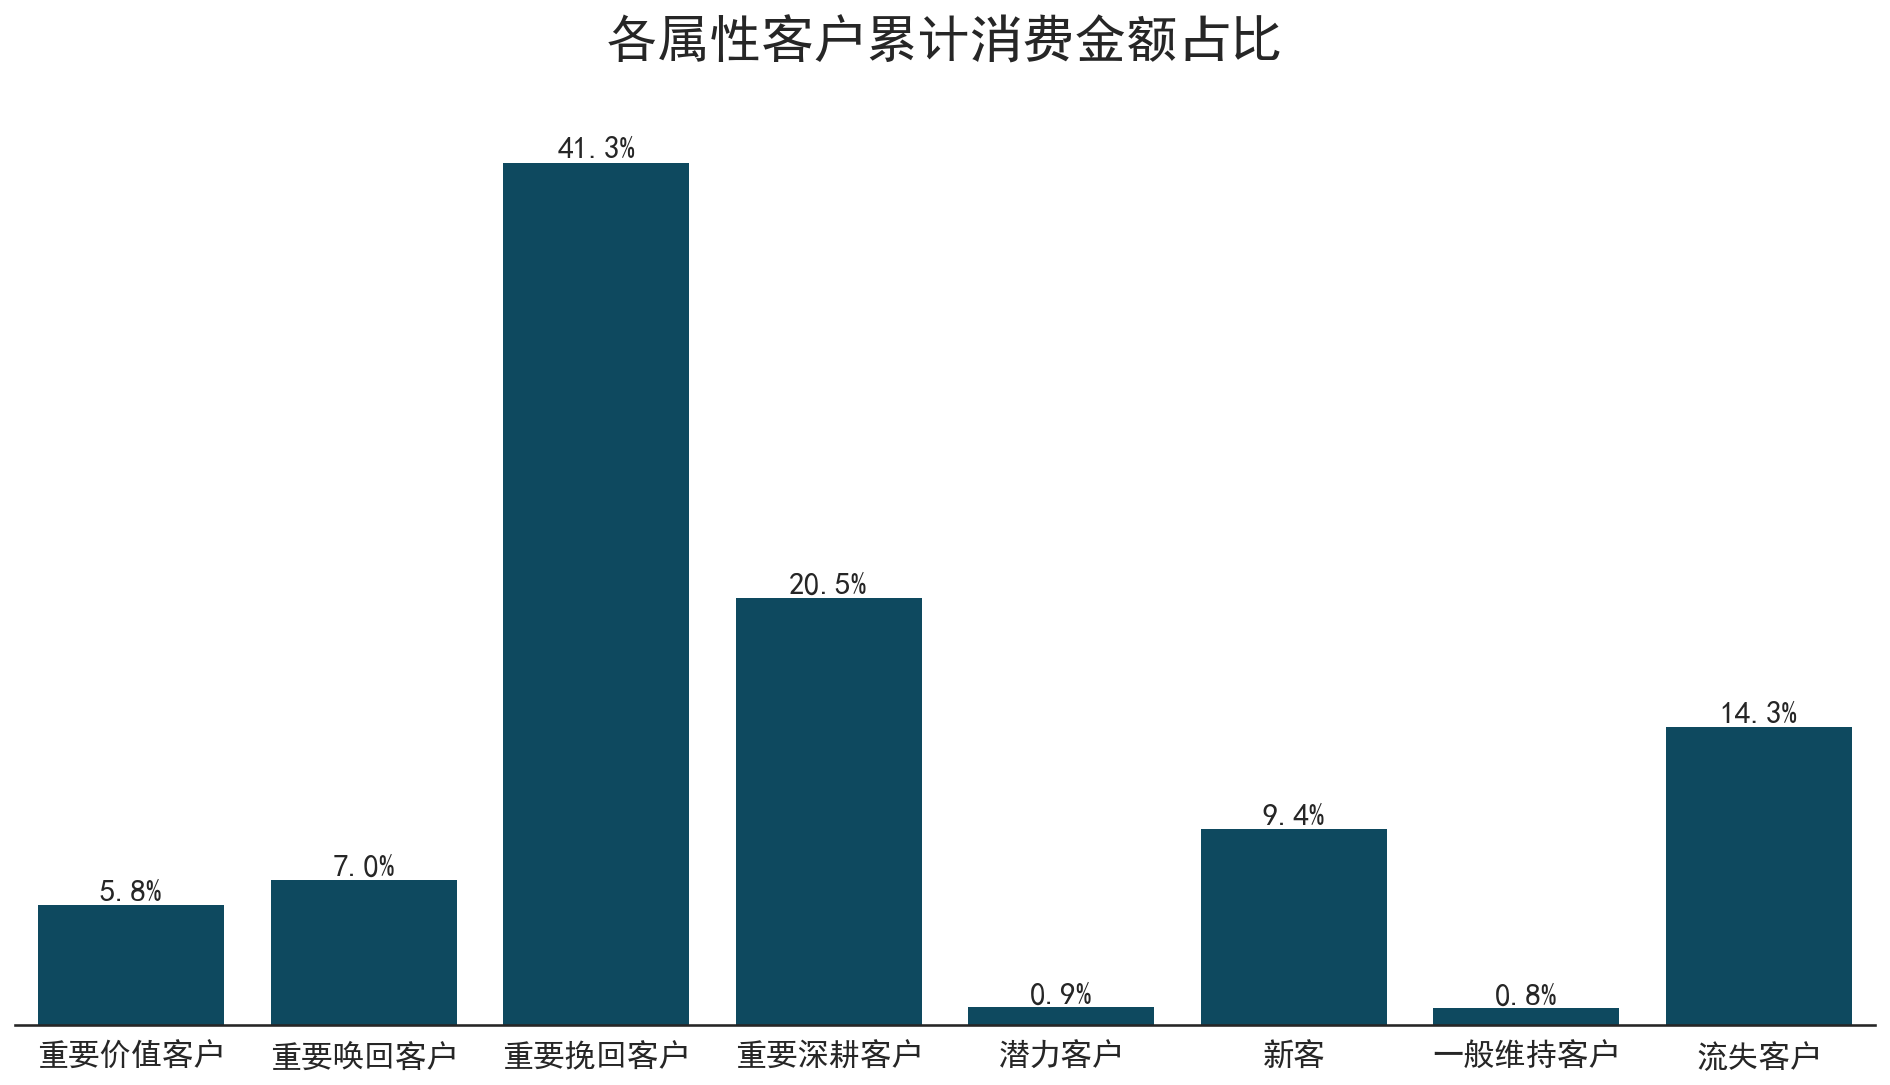

In [22]:
fig = plt.figure(figsize=(16,8),dpi=150)
sns.barplot(df_rfm_money.index,df_rfm_money,color='#004f6d')
x = np.arange(len(df_rfm_money))
y = df_rfm_money.values
for a,b in zip(x,y):
    plt.text(a, b+10, '{:.1f}%'.format(b/sum(df_rfm_money)*100), ha='center', va= 'bottom',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([])
plt.xlabel('',fontsize=15)
plt.ylabel('')
plt.title('各属性客户累计消费金额占比\n',size=25)
sns.despine(left=True)
plt.show()

In [23]:
df_rfm = rfm.groupby(['rfm_comb'])['r_interval'].count().reindex(['111','011','001','101','110','100','010','000'])
df_rfm = df_rfm.rename(index={'111':'重要价值客户','011':'重要唤回客户','101':'重要深耕客户','001':'重要挽回客户',
                     '110':'潜力客户','010':'一般维持客户','100':'新客','000':'流失客户'})

In [24]:
df_rfm

rfm_comb
重要价值客户     581
重要唤回客户     836
重要挽回客户    6765
重要深耕客户    2558
潜力客户       290
新客        5168
一般维持客户     347
流失客户      8874
Name: r_interval, dtype: int64

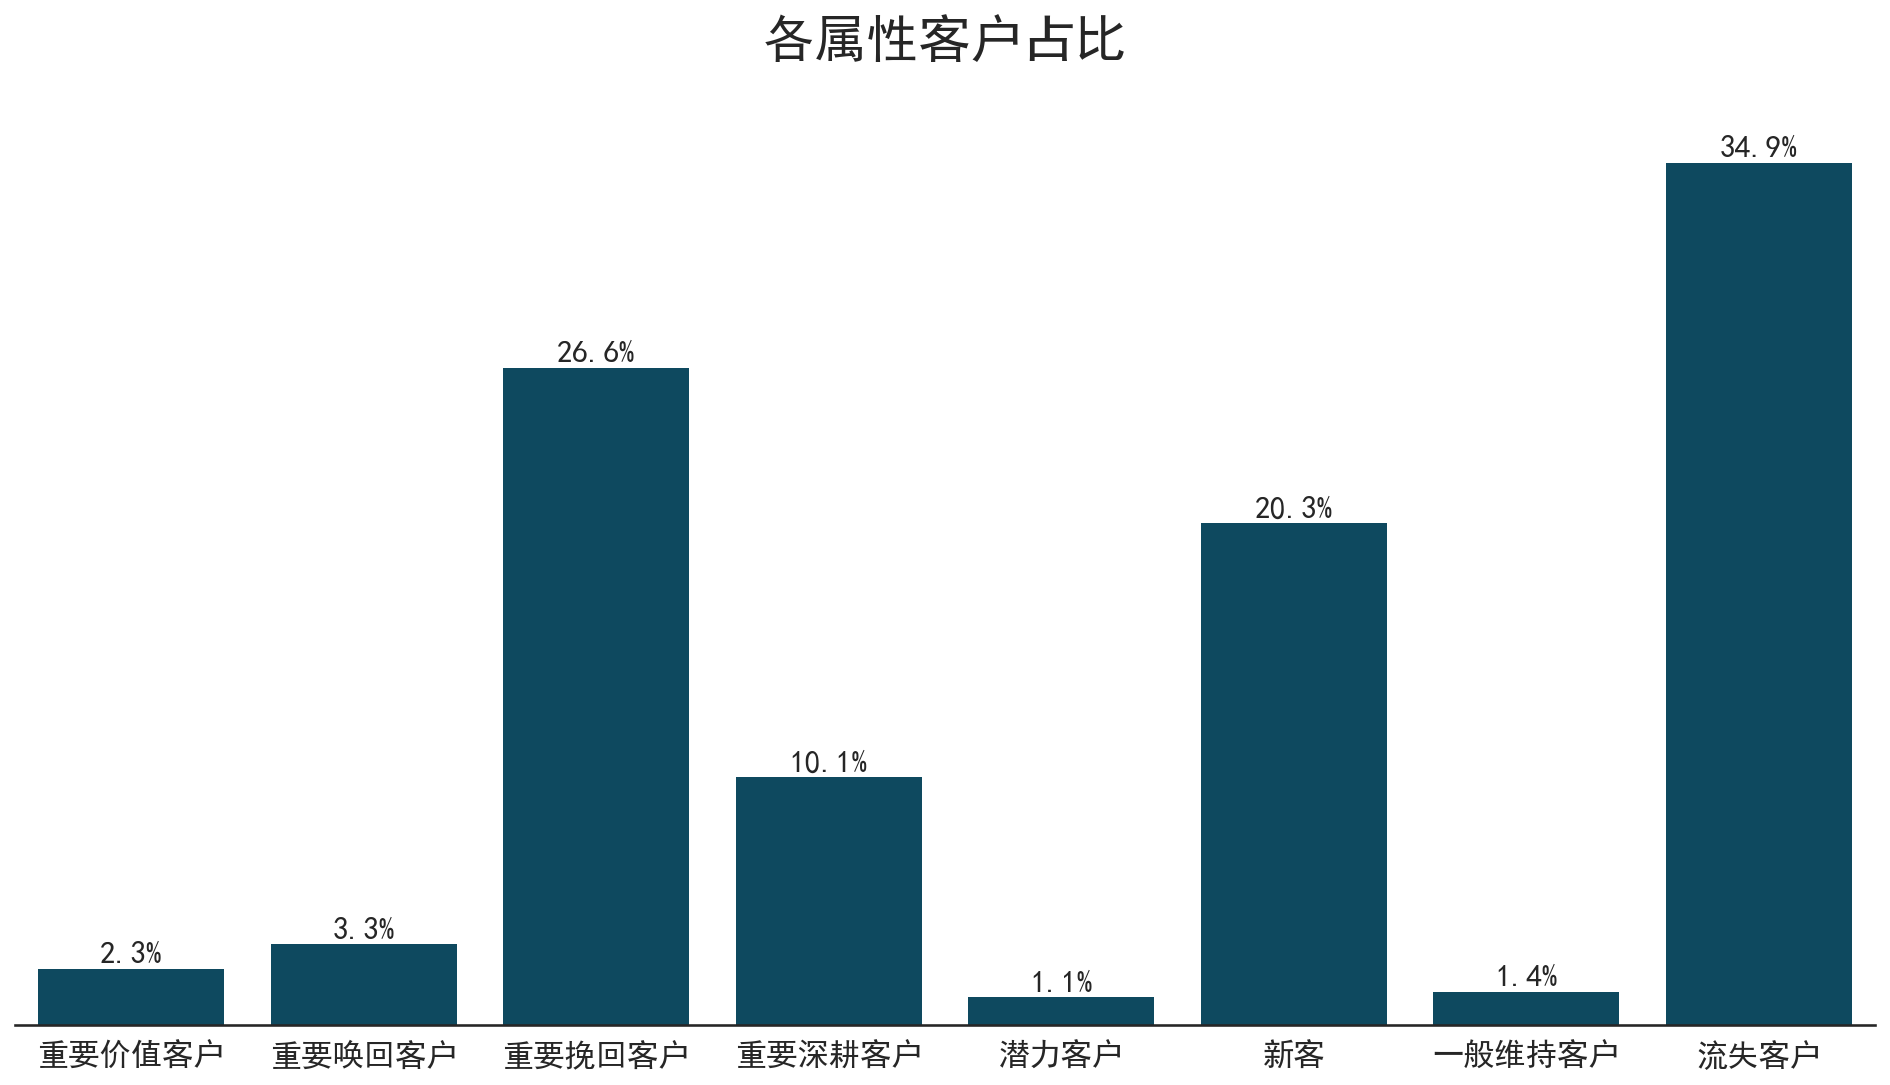

In [25]:
fig = plt.figure(figsize=(16,8),dpi=150)
sns.barplot(df_rfm.index,df_rfm,color='#004f6d')
x = np.arange(len(df_rfm))
y = df_rfm.values
for a,b in zip(x,y):
    plt.text(a, b+10, '{:.1f}%'.format(b/sum(df_rfm)*100), ha='center', va= 'bottom',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([])
plt.xlabel('',fontsize=15)
plt.ylabel('')
plt.title('各属性客户数量占比\n',size=25)
sns.despine(left=True)
plt.show()

基于上图和订单源数据，我们发现：
- 流失客户占比最高34.9%，通过浏览源数据发现，这部分客户集中在去年双11下单，属价格敏感型客户，在618大促可尝试对其进行唤醒。
- 挽回客户人数占比26.6%，但支付金额占比最高。也就是说，对店铺销售贡献最高的客户，下单时间远、购买频次低，已经濒于流失边缘。他们和流失客户的区别在于他们平均消费金额较高，
 - 抽样进行回访，调查客户沉睡原因；
 - 筛选其购买的产品，结合复购率进行分析，是未到回购周期，还是产品复购率本身就很低，店铺近期拉新乏力，导致挽回客户消费金额占比最高。


## 总结与思考

### 模型实施

- 根据不同分层客户制定相应的营销策略。
- 将客户RFM得分排序，选择RFM得分最高的群体进行促销。
- 抽选择部分客户进行促销活动，然后根据客户的响应数据，建立RFM为自变量的响应模型，然后根据模型对目标用户进行客户响应打分，选择可能响应客户进行促销，提升促销的ROI。

### 优化和改进

- 采用k-means聚类算法将用户类型分为4~5类，更有益于营销策略的制定。
- 增加R、F、M三个指标之外的字段，例如年龄地区等，具体的话还是需要结合具体业务分析，但另一方面来说，R、F、M三个指标来衡量用户的消费行为已较为全面，如果没有特殊需要不建议增加维度，以免适得其反和增加最后的结果解读难度。